In [20]:
import pandas as pd
import os

# 현재 파이썬 코드의 파일 경로
current_path = os.getcwd()  # 현재 작업 디렉토리를 가져옵니다.

# CSV 파일 경로
file_path = os.path.join(current_path, 'filtered_data.csv')  # User uploaded fioytle to this path

df = pd.read_csv(file_path)
df

,note id,person id,age,gender source value,BMI,admission department,division,ward,asa class,surgeon id,...,condition source value,surgery room,previous surgery,emergency status,op timing,day of the week,week of the month,month,surgeon estimated op time,surgery duration
0,101058,29,81,F,25.247087,General Surgery,Admission,NUGW2,2,9885,...,D00002196,203,N,N,TF2,Thursday,4th,October,130,66
1,57801,64,60,F,24.376249,Otolaryngology,Admission,102,2,6194,...,D00003798,504,N,N,8A,Friday,2nd,January,300,130
2,71288,64,60,F,24.376249,Otolaryngology,Admission,102,3,6194,...,D00003798,504,Y,N,TF4,Monday,4th,April,100,85
3,135104,64,60,F,24.376249,Otolaryngology,Admission,102,3,6194,...,D00003798,504,Y,N,TF2,Monday,3rd,August,100,83
4,221210,71,94,M,27.963140,Orthopedics,Admission,41,2,29473,...,D00018711,108,N,N,TF4,Monday,5th,March,100,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161214,297111,4055249,1,M,23.700428,Pediatric Surgery,Admission,5A,1,100613,...,D00011688,5,N,Y,etc,Tuesday,2nd,September,200,123
161215,297455,4055328,1,M,20.612160,Pediatric Urology,Day,PDSC,1,6259,...,D00016707,7,N,N,8A,Monday,4th,September,130,45
161216,297761,4055407,1,M,12.502703,Pediatric Surgery,Admission,5A,2,105057,...,D00011524,5,N,N,8A,Wednesday,3rd,September,130,43
161217,297753,4055558,4,F,14.365794,Pediatric Surgery,Admission,5A,2,105057,...,D00004831,5,N,N,TF6,Wednesday,3rd,September,130,82


In [21]:
from sklearn.model_selection import train_test_split

# Removing unnecessary columns
df.drop(columns=['note id', 'person id', 'surgeon estimated op time', 'final op name'], inplace=True)

# Encoding binary columns
binary_cols = ['condition source value', 'surgeon id', 'ward', 'surgery room', 'op code']
for col in binary_cols:
    df[col] = df[col].astype('category').cat.codes

# One-hot encoding for other categorical columns
one_hot_cols = ['surgical department', 'op timing', 'month', 'anesthesia type',
                'day of the week', 'asa class', 'week of the month', 
                'division', 'previous surgery', 'emergency status', 'gender source value', 
                'admission department']
df_encoded = pd.get_dummies(df, columns=one_hot_cols)

# Splitting the data
X_all = df_encoded.drop("surgery duration", axis=1)
y_all = df_encoded["surgery duration"]
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Displaying the first few rows of the resulting dataframe
X_train_all
y_train_all


61344     122
137241     48
139478     76
113549     36
149411    127
         ... 
119879     76
103694     57
131932    311
146867     82
121958     57
Name: surgery duration, Length: 128975, dtype: int64

In [22]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

cross_val_scores_rf = {}

# Preparing department-specific datasets
departments = df['surgical department'].unique()
department_models = {}
predictions = {}


# Training models for each department
for dept in departments:
    # Adjusting column name
    dept_col_name = 'surgical department_' + dept

    # Filtering data for the department
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    X_dept = dept_data.drop('surgery duration', axis=1)
    y_dept = dept_data['surgery duration'] 

    # Splitting the data
    X_train_dept, X_test_dept, y_train_dept, y_test_dept = train_test_split(X_dept, y_dept, test_size=0.2, random_state=42)

    # Training the model with cross-validation
    department_model = RandomForestRegressor(random_state=42)
    cv_scores_rf = cross_val_score(department_model, X_dept, y_dept, cv=5)
    cross_val_scores_rf[dept] = cv_scores_rf.mean()

    # Training and saving the final model
    department_model.fit(X_train_dept, y_train_dept)
    department_models[dept] = department_model

    # Making predictions on the test dataset
    predictions[dept] = department_model.predict(X_test_dept)

# Dictionary to store the MAE for each department
mae_per_department = {}

# Preparing for ensemble
final_predictions = np.zeros(len(X_test_all))
test_indices = X_test_all.index

# Applying each department-specific model to the entire test dataset
for dept, department_model in department_models.items():
    # Adjusting column name
    dept_col_name = 'surgical department_' + dept

    # Indices of test data belonging to the department
    dept_indices = X_test_all[X_test_all[dept_col_name] == 1].index

    # Calculating predictions for the department
    dept_predictions = department_model.predict(X_test_all.loc[dept_indices])

    # Updating the final prediction array
    final_predictions[np.isin(test_indices, dept_indices)] = dept_predictions
    
    # Evaluating MAE for the department
    dept_mae_rf = mean_absolute_error(y_test_all.loc[dept_indices], dept_predictions)
    mae_per_department[dept] = dept_mae_rf

# Evaluating performance
mae_rf = mean_absolute_error(y_test_all, final_predictions)
rmse_rf = np.sqrt(mean_squared_error(y_test_all, final_predictions))
r2_rf = r2_score(y_test_all, final_predictions)

# The code is now updated with model names changed to 'department_model'
mae_rf, rmse_rf, r2_rf

print(f"Ensemble MAE: {mae_rf}, RMSE: {rmse_rf}, R²: {r2_rf}")

Ensemble MAE: 16.62513925071331, RMSE: 31.609588222762078, R²: 0.916107368799772


In [23]:
mae_per_department

{'General Surgery': 17.97449758787043,
 'Otolaryngology': 21.29770025839793,
 'Orthopedics': 17.735042092603727,
 'Ophthalmology': 6.711396085204375,
 'Obstetrics & Gynecology': 17.513872782345302,
 'Urology': 11.764183187946074,
 'Plastic Surgery': 20.812400000000004,
 'Neurosurgery': 24.830393220338983,
 'Cardiovascular Thoracic Surgery': 24.109567053854278,
 'Pediatric Otolaryngology': 11.368510078878177,
 'Pediatric Orthopedics': 23.24108723135272,
 'Pediatric Thoracic Surgery': 25.550911458333335,
 'Pediatric Urology': 15.806160558464224,
 'Pediatric Surgery': 15.678263971462545,
 'Pediatric Ophthalmology': 5.260770202020201,
 'Pediatric Plastic Surgery': 16.823589164785552,
 'Pediatric Neurosurgery': 31.814077253218887}

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_41324\1705992803.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y=top_20_features.index, data=top_20_features, palette="viridis")


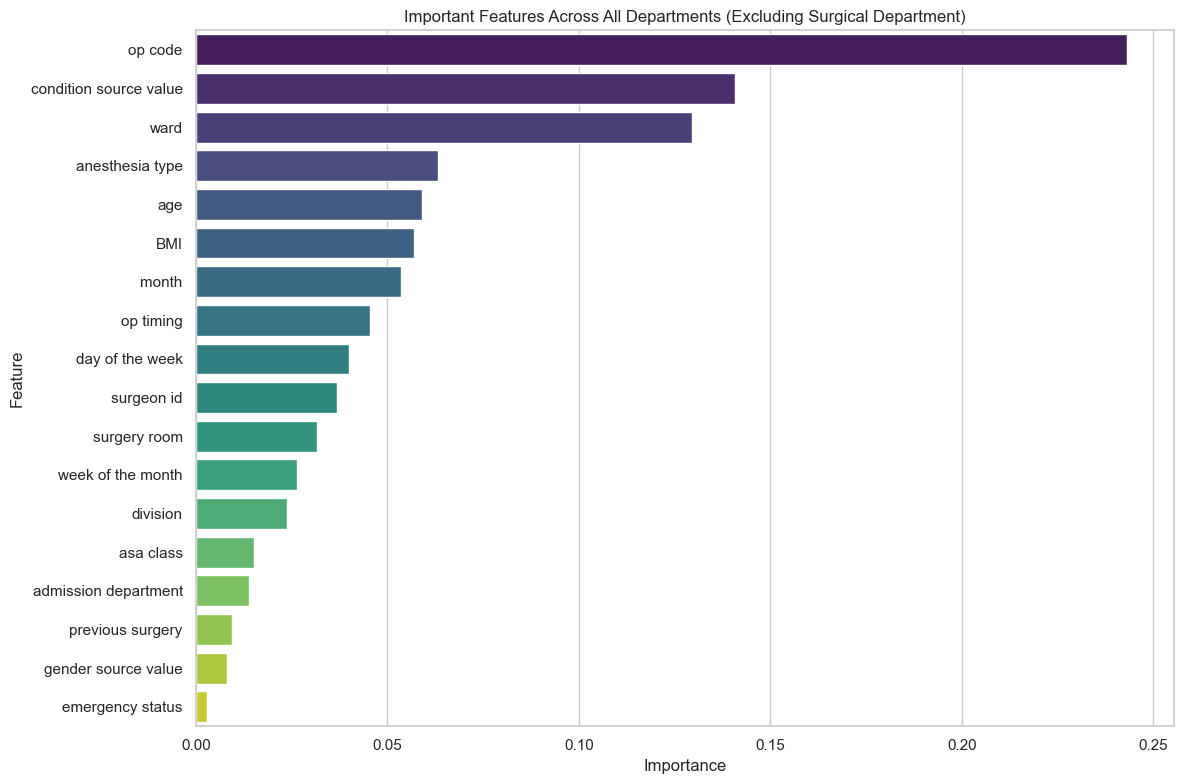

In [24]:
import seaborn as sns

# Calculating feature importances
feature_importances = department_model.feature_importances_

# Extracting feature names
feature_names = X_train_dept.columns

# Initialize a DataFrame to store aggregated feature importances
aggregated_importances = pd.DataFrame(index=feature_names, columns=['Importance'])
aggregated_importances['Importance'] = 0

# Aggregate feature importances from each department-specific model
for dept in departments:
    department_model = department_models[dept]
    importances = department_model.feature_importances_
    aggregated_importances['Importance'] += importances

# Averaging the importances across all models
aggregated_importances['Importance'] /= len(departments)

# Integrating one-hot encoded features
for feature in one_hot_cols:
    # Find all one-hot encoded features for this original feature
    one_hot_features = [col for col in aggregated_importances.index if col.startswith(feature + '_')]
    # Sum their importances
    total_importance = aggregated_importances.loc[one_hot_features, 'Importance'].sum()
    # Remove the individual one-hot features and add the total importance to the original feature
    aggregated_importances = aggregated_importances.drop(one_hot_features)
    aggregated_importances.loc[feature] = total_importance

# Exclude 'surgical department' feature from aggregated importances
aggregated_importances = aggregated_importances.drop(index=[col for col in aggregated_importances.index if col.startswith('surgical department')])

# Sorting and selecting top 20 features (excluding 'surgical department')
top_20_features = aggregated_importances.sort_values(by='Importance', ascending=False).head(20)

# Enhancing graph aesthetics
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
sns.barplot(x='Importance', y=top_20_features.index, data=top_20_features, palette="viridis")
plt.title('Important Features Across All Departments (Excluding Surgical Department)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_41324\2873902153.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y=top_20_features.index, data=top_20_features, palette="viridis")


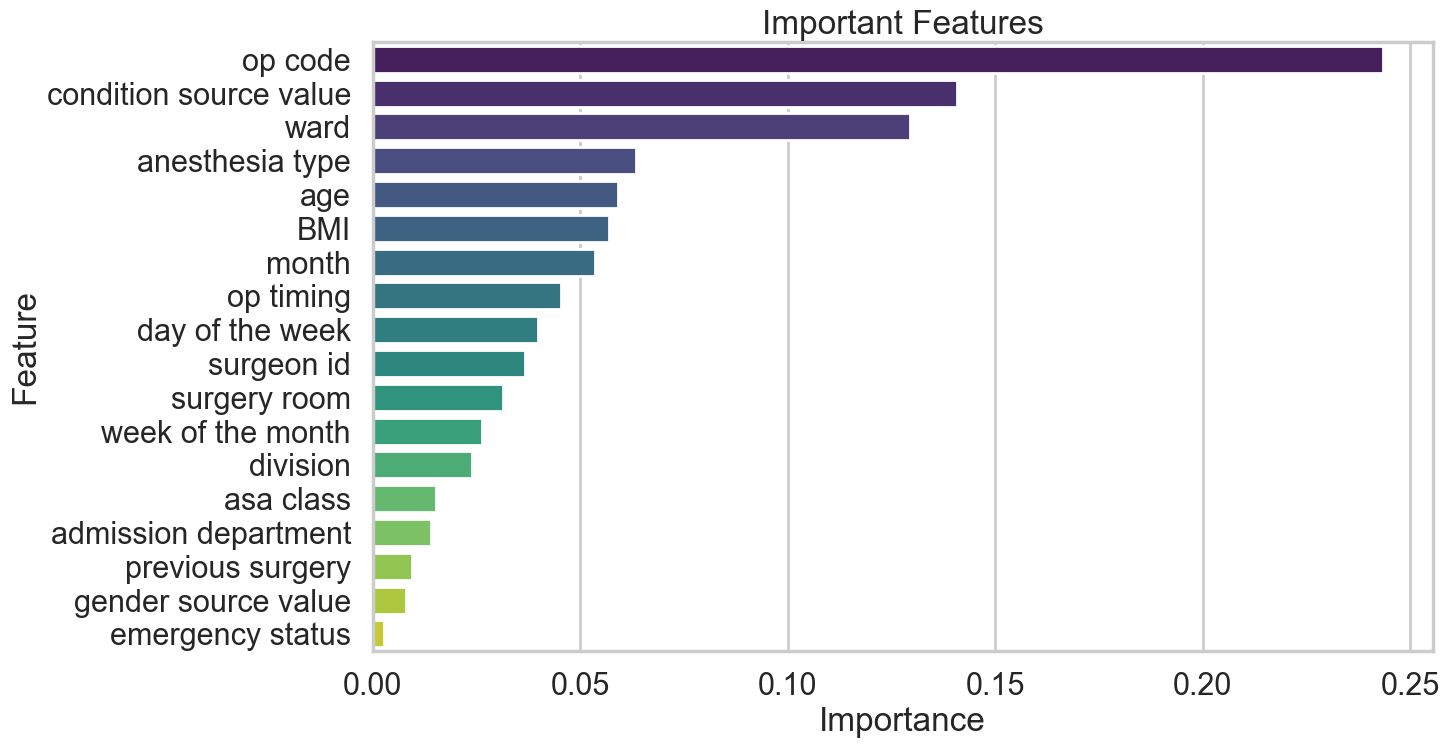

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the context and font scale to increase font size
sns.set_context("poster")  # You can adjust the font_scale value as needed

# Your existing code

# Enhancing graph aesthetics
plt.figure(figsize=(15, 8))
sns.barplot(x='Importance', y=top_20_features.index, data=top_20_features, palette="viridis")
plt.title('Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [26]:
# Dictionary to store the MAE for each department
mae_per_department = {}

# Evaluating MAE for each department
for dept, rf_model in department_model.items():
    # Adjusting column name
    dept_col_name = 'surgical department_' + dept

    # Indices of test data belonging to the department
    dept_indices_rf = X_test_all[X_test_all[dept_col_name] == 1].index

    # Calculating predictions for the department
    dept_rf_predictions = rf_model.predict(X_test_all.loc[dept_indices_rf])

    # Evaluating MAE for the department
    dept_mae_rf = mean_absolute_error(y_test_all.loc[dept_indices_rf], dept_rf_predictions)
    mae_per_department[dept] = dept_mae_rf

mae_per_department


AttributeError: 'RandomForestRegressor' object has no attribute 'items'